In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [18]:
# Load annotation data
#info = pd.read_table('global_ID_mapping.txt', dtype = 'str', index_col = 0)
info = pd.read_csv('global_ID_mapping_NA.tsv', dtype = str, index_col = 0, sep = '\t')
scFEA_info = pd.read_csv('/Users/elias/MEBOCOST/data/scFEA/Human_M168_information.symbols.csv', index_col = 0)
mebocost_info = pd.read_csv('/Users/elias/MEBOCOST/data/mebocost_db/common/metabolite_annotation_HMDB_summary.tsv', sep = '\t', index_col = 1)

# Load metabolomic dataset from cosmos https://github.com/saezlab/COSMOS_MSB/blob/main/data/metab_raw_metabolomic.csv and predictions from mebocost and scFEA
metab_true = pd.read_csv('raw_metabolomic_vsn.csv', index_col = 0).sort_index() #metab_raw_metabolomic.csv
scFEA_metab = pd.read_csv('balance_20221202-105743.csv', index_col = 0).T.sort_index()
mebocost_pred = pd.read_csv('met_mat_default.csv', index_col = 0).sort_index()

In [19]:
# Order the column names that they are similar (yeah i know, very hard coded)
metab_true2 = metab_true.iloc[:,[8,0,9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6, 15, 7,]]
scFEA2 = scFEA_metab.iloc[:,[0,1,2,3,4,5,6,7,8,9,12,13,18, 19, 20, 21]]
scFEA2.columns = metab_true2.columns
mebocost_pred = mebocost_pred.iloc[:,[0,1,2,3,4,5,6,7,8,9,12,13,18, 19, 20, 21]] 
mebocost_pred.columns = metab_true2.columns

In [20]:
# Convert indices to metabolite names and upper 

# Metabolomics dataset
upper_names = [x.upper() for x in metab_true.index]
metab_GT = metab_true2
metab_GT.index = upper_names

# Mebocost predictions
mebocost_names = []
for name in mebocost_pred.index:
    if name in list(mebocost_info.iloc[:,0]):
        metabolite_line = mebocost_info[mebocost_info.iloc[:,0] == name]
        metabolite = metabolite_line.iloc[0,2]
        mebocost_names.append(metabolite.upper())
mebocost_pred.index = mebocost_names

# scFEA predictions
upper_names = [x.upper() for x in scFEA2.index]
scFEA_pred = scFEA2
scFEA_pred.index = upper_names

# Upper annotation index
info.index = [x.upper() for x in info.index]

In [21]:
def remove_unknown_metabs(matrix):
    in_bool = [x in info.index for x in matrix.index]
    elements_in = np.sum(in_bool)
    elements_matrix = np.shape(matrix.index)[0]
    matrix_in = matrix.iloc[in_bool, :]

    print('List elements: ' + str(elements_matrix))
    print('List elements in info: ' + str(elements_in))
    print('Elements missing: ' + str(elements_matrix - elements_in))  

    return(matrix_in)  

In [22]:
# Remove unwanted columns from the matrices
matrices = [metab_GT, mebocost_pred, scFEA_pred]
matrices_clean = [remove_unknown_metabs(x) for x in matrices]        

List elements: 107
List elements in info: 95
Elements missing: 12
List elements: 550
List elements in info: 314
Elements missing: 236
List elements: 70
List elements in info: 54
Elements missing: 16


In [23]:
def get_correlation(GT_matrix = matrices_clean[0], pred_matrix = matrices_clean[1]):
    intersection1 = [x in GT_matrix.index for x in pred_matrix.index]
    intersection2 = [x in pred_matrix.index for x in GT_matrix.index]
    num_intersection = np.sum(intersection1)
    GT_subs = GT_matrix.iloc[intersection2, :].fillna(0).sort_index()
    pred_subs = pred_matrix.iloc[intersection1, :].fillna(0).sort_index()
    
    corr = GT_subs.corrwith(pred_subs, axis = 1)
    
    print('Intersection elements: ' + str(num_intersection))
    print(corr)
    
    return(corr)

In [24]:
mebocost = get_correlation(matrices[0], matrices[1])
scFEA = get_correlation(matrices[0], matrices[2])

Intersection elements: 34
ADENINE                 0.073658
ADENOSINE              -0.018241
ADP                    -0.137138
ASCORBIC ACID           0.027961
CARBAMOYL PHOSPHATE    -0.261454
CDP                     0.237076
CHOLINE                 0.275558
CITRULLINE              0.664440
CREATINE               -0.065076
CYTIDINE                0.493850
ETHANOLAMINE           -0.583645
FRUCTOSE 6-PHOSPHATE    0.158028
GLUCOSE 6-PHOSPHATE    -0.043867
GLYCEROL               -0.631449
GLYCINE                 0.018978
GUANINE                 0.797002
GUANOSINE               0.150410
HYPOTAURINE             0.053874
HYPOXANTHINE            0.438593
INOSINE                -0.272045
LINOLEIC ACID           0.196540
MYRISTIC ACID          -0.202279
NAD                    -0.571293
OLEIC ACID             -0.503055
ORNITHINE               0.248188
PALMITIC ACID          -0.203989
PALMITOYLCARNITINE      0.306165
QUINOLINIC ACID         0.110614
RIBOFLAVIN              0.870272
SORBITOL         

<AxesSubplot: >

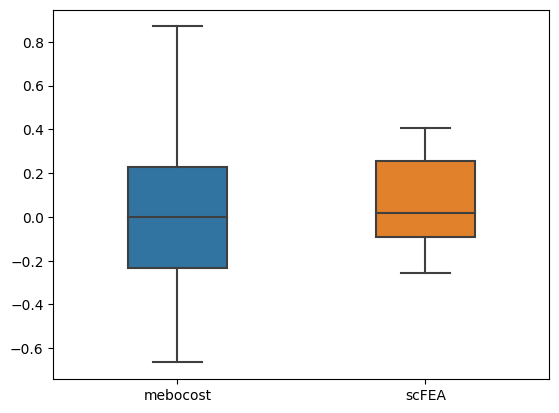

In [25]:
df = pd.Series(mebocost, name="mebocost").to_frame().join(pd.Series(scFEA, name="scFEA"))
sns.boxplot(data=df, width = 0.4) 